# Import Libraries

This cell imports various libraries needed for data manipulation, visualization, and model building. These include:

- **NumPy and Pandas**: For numerical and data manipulation.
- **Matplotlib and Seaborn**: For plotting and visualizing data.
- **TensorFlow and Keras**: For building and training deep learning models.
- **os, random, and shutil**: For file operations and handling directories.
- **sklearn**: For evaluating the model's performance using metrics like classification report and confusion matrix.


In [2]:
import os
import random
import shutil
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Activation, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')

2026-01-31 11:23:26.327594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769858606.504877      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769858606.558955      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769858606.985680      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769858606.985716      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769858606.985718      55 computation_placer.cc:177] computation placer alr

#  Data Configuration, Augmentation, and Visualization

In this section, we establish the data pipeline, which is critical for training a robust model. This block performs three key tasks:

### 1. Configuration & Verification
We define the dataset path and set essential hyperparameters:
* **Batch Size (32):** The number of samples processed before the model is updated.
* **Image Size (224x224):** The target resolution for resizing images (standard for ResNet architectures).

### 2. Data Augmentation
To prevent **overfitting** and improve the model's ability to generalize, we use `ImageDataGenerator`:
* **Training Set:** We apply geometric transformations such as **rotation, width/height shifts, shear, zoom, and horizontal flipping**. This artificially increases the diversity of the training data.
* **Validation Set:** We **only rescale** pixel values (normalization) without applying transformations. This ensures we evaluate the model on "real," undistorted images.



### 3. Loading & Visualization (EDA)
We use `flow_from_directory` to load images and automatically infer class labels from the folder structure. Finally, we plot **Pie Charts** to visualize the **Class Distribution**. This step is vital to check for dataset imbalance (e.g., if one animal class has significantly more images than others).

 Target Directory: /kaggle/input/animal-5-mammal/Animal/train
 Number of classes: 5
 Classes: ['HORSE', 'LION', 'dog', 'ELEPHANT', 'cat']

--- LOADING TRAINING DATA ---
Found 10799 images belonging to 5 classes.

--- LOADING VALIDATION DATA ---
Found 2697 images belonging to 5 classes.


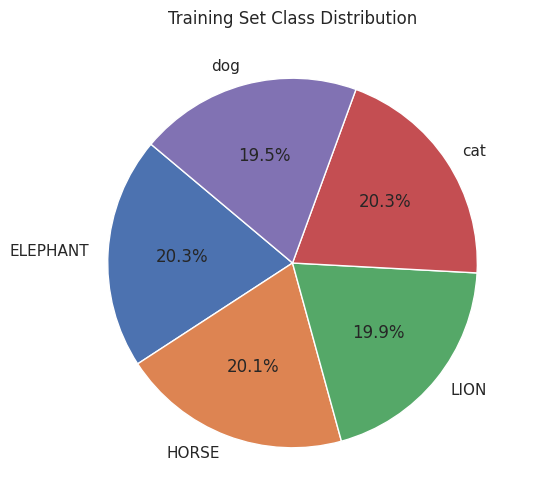

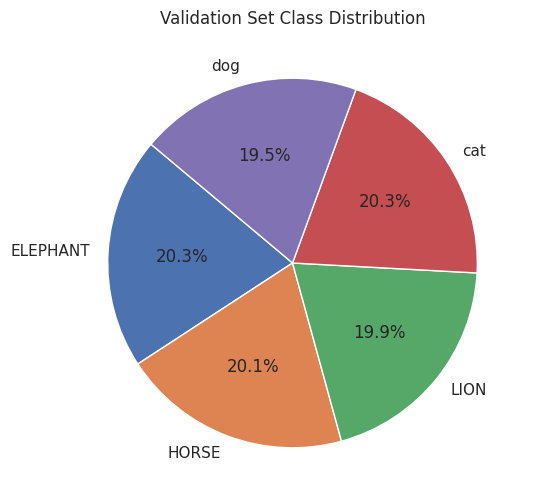

In [3]:
data_path = '/kaggle/input/animal-5-mammal/Animal/train' 

if not os.path.exists(data_path):
    print(f" Warning: Path not found at {data_path}")
    print("Trying alternative path...")
    data_path = '/kaggle/input/animal-5-mammal/Animal' 



batch_size = 32
img_size = 224

try:
    classes = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]
    num_classes = len(classes)
    print(f" Target Directory: {data_path}")
    print(f" Number of classes: {num_classes}")
    print(f" Classes: {classes}")
except:
    print(" Error reading the directory. Check the path again.")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.20
)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20
)

print("\n--- LOADING TRAINING DATA ---")
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

print("\n--- LOADING VALIDATION DATA ---")
validation_generator = validation_datagen.flow_from_directory(
    data_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)


def plot_class_distribution_pie(generator, title):
    if generator.samples == 0:
        print(f"Skipping plot for {title}: No images found.")
        return
        
    class_counts = np.sum(generator.classes == np.arange(num_classes)[:, None], axis=1)
    plt.figure(figsize=(10, 6))
    plt.pie(class_counts, labels=list(generator.class_indices.keys()), autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

plot_class_distribution_pie(train_generator, 'Training Set Class Distribution')
plot_class_distribution_pie(validation_generator, 'Validation Set Class Distribution')

# Training Callbacks Configuration

This cell sets up various callbacks to enhance the training process and ensure optimal performance of the models. The following callbacks are defined:

1. **Model Checkpoints**:
    - **ResNet50v2 Checkpoint**: `checkpoint_resnet50v2`
        - Saves the best model based on validation performance.
        - The model is saved with the filename `resnet50v2.keras`.
        - Verbose output is enabled to display saving status.
    - **Custom CNN Checkpoint**: `checkpoint_cnn`
        - Similar to the ResNet50v2 checkpoint but saves the model with the filename `custon-cnn.keras`.

2. **Early Stopping**:
    - The `earlystopping` callback monitors the validation loss (`val_loss`).
    - If there is no improvement in validation loss for 10 consecutive epochs (`patience=10`), training stops early.
    - The best model weights are restored (`restore_best_weights=True`).

3. **Learning Rate Reduction**:
    - The `learning_rate_reduction` callback reduces the learning rate if the validation loss plateaus.
    - Monitors the validation loss (`val_loss`) and reduces the learning rate by a factor of 0.2 (`factor=0.2`) if no improvement is seen for 5 epochs (`patience=5`).
    - The minimum learning rate is set to 0.0001.

These callbacks help in optimizing the training process by saving the best models, preventing overfitting, and adjusting the learning rate dynamically.

In [4]:
model_name_resnet50v2 = "resnet50v2.keras"
model_name_cnn = 'custon-cnn.keras'

checkpoint_resnet50v2 = ModelCheckpoint(
    model_name_resnet50v2,
   
    save_best_only = True,
    verbose=1
)

checkpoint_cnn = ModelCheckpoint(
    model_name_cnn,
   
    save_best_only = True,
    verbose=1
)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0, 
    patience = 10, 
    verbose = 1, 
    restore_best_weights=True
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=5, 
    factor=0.2, 
    min_lr=0.0001)

#  Build Custom CNN Model

This cell defines the `build_custom_cnn` function, which constructs a custom Convolutional Neural Network (CNN) model using the Keras Sequential API. The function takes two parameters:

- `img_size`: The size to which each image will be resized (input dimension).
- `num_classes`: The number of output classes for classification.

The model architecture consists of the following layers:

1. **Input Layer**:
    - Explicitly defines the input shape as `(img_size, img_size, 3)` to handle RGB images.

2. **First Convolutional Block**:
    - `Conv2D` layer with 32 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

3. **Second Convolutional Block**:
    - `Conv2D` layer with 64 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

4. **Third Convolutional Block**:
    - `Conv2D` layer with 128 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

5. **Fourth Convolutional Block**:
    - `Conv2D` layer with 256 filters, a 3x3 kernel, and ReLU activation.
    - `MaxPooling2D` layer with a 2x2 pool size.

6. **Flatten and Fully Connected Layers**:
    - `Flatten` layer to convert the 2D matrix data into a 1D vector.
    - `Dense` layer with 512 units and ReLU activation.
    - `Dropout` layer with a dropout rate of 0.5 to prevent overfitting.
    - `Dense` layer with `num_classes` units and softmax activation for multi-class classification.

The model is compiled with the `categorical_crossentropy` loss function, `Adam` optimizer, and `accuracy` as the evaluation metric. The model summary is printed to provide an overview of the architecture.

The function returns the compiled model, ready for training.

In [5]:

def build_custom_cnn(img_size, num_classes):
    model = Sequential()
   
    model.add(Input(shape=(img_size, img_size, 3)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()

    return model

model = build_custom_cnn(img_size, num_classes)

I0000 00:00:1769858638.664426      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265,861 (73.49 MB)

 Trainable params: 19,265,861 (73.49 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Custom CNN Model

This cell initiates the training process for the custom CNN model using the `fit` method. The training setup includes:

1. **Training Data**:
    - `train_generator`: The data generator for the training dataset, which provides batches of augmented images during training.

2. **Training Parameters**:
    - `epochs`: The number of epochs to train the model, set to 50.

3. **Validation Data**:
    - `validation_generator`: The data generator for the validation dataset, which provides batches of images for evaluating the model's performance during training.

4. **Callbacks**:
    - `checkpoint_cnn`: Saves the best model based on validation performance.
    - `earlystopping`: Stops training early if the validation loss does not improve for 10 consecutive epochs.
    - `learning_rate_reduction`: Reduces the learning rate if the validation loss plateaus for 5 epochs.

The training history, including metrics such as loss and accuracy for both the training and validation sets, is stored in the `history` variable for further analysis and visualization.

In [6]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint_cnn, earlystopping, learning_rate_reduction]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1769858644.304128     135 service.cc:152] XLA service 0x789f5800cb70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769858644.304162     135 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1769858644.735625     135 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/338 ━━━━━━━━━━━━━━━━━━━━ 45:00 8s/step - accuracy: 0.1875 - loss: 1.6013

I0000 00:00:1769858649.738905     135 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.2725 - loss: 1.6149
Epoch 1: val_loss improved from inf to 1.08919, saving model to custon-cnn.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 263s 756ms/step - accuracy: 0.2727 - loss: 1.6146 - val_accuracy: 0.5851 - val_loss: 1.0892 - learning_rate: 0.0010
Epoch 2/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.5111 - loss: 1.2069
Epoch 2: val_loss improved from 1.08919 to 0.71076, saving model to custon-cnn.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 133s 393ms/step - accuracy: 0.5113 - loss: 1.2066 - val_accuracy: 0.6986 - val_loss: 0.7108 - learning_rate: 0.0010
Epoch 3/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.6508 - loss: 0.8827
Epoch 3: val_loss improved from 0.71076 to 0.57055, saving model to custon-cnn.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 134s 396ms/step - accuracy: 0.6509 - loss: 0.8825 - val_accuracy: 0.7590 - val_loss: 0.5705 - learning_rate: 0.0010
Epoch 4/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accur

# Plotting and Evaluating the Custom CNN

This cell performs the visualization and evaluation of the custom CNN model's performance after training. The steps include:

1. **Plotting Training and Validation Metrics**:
    - The `plot_history` function creates two subplots:
        - **Loss Plot**: Displays the training and validation loss over the epochs.
        - **Accuracy Plot**: Shows the training and validation accuracy over the epochs.
    - This helps visualize how well the model is learning and if there is any overfitting or underfitting.

2. **Evaluating the Model**:
    - Resets the `validation_generator` to ensure predictions are made on the entire validation set.
    - Uses the trained model to make predictions on the validation set.
    - Converts the predicted probabilities to class labels using `np.argmax`.
    - Retrieves the true class labels from the validation generator.
    - Generates a classification report using `classification_report` from sklearn, which includes precision, recall, and F1-score for each class.

3. **Confusion Matrix**:
    - Computes the confusion matrix using `confusion_matrix` from sklearn, which shows the true vs. predicted labels.
    - Plots a heatmap of the confusion matrix using Seaborn to visualize the model's performance and identify any misclassifications.
    - The heatmap provides a clear picture of how well the model is performing for each class, highlighting areas where it may be making errors.

These steps provide a comprehensive evaluation of the model's performance and help in understanding its strengths and weaknesses.

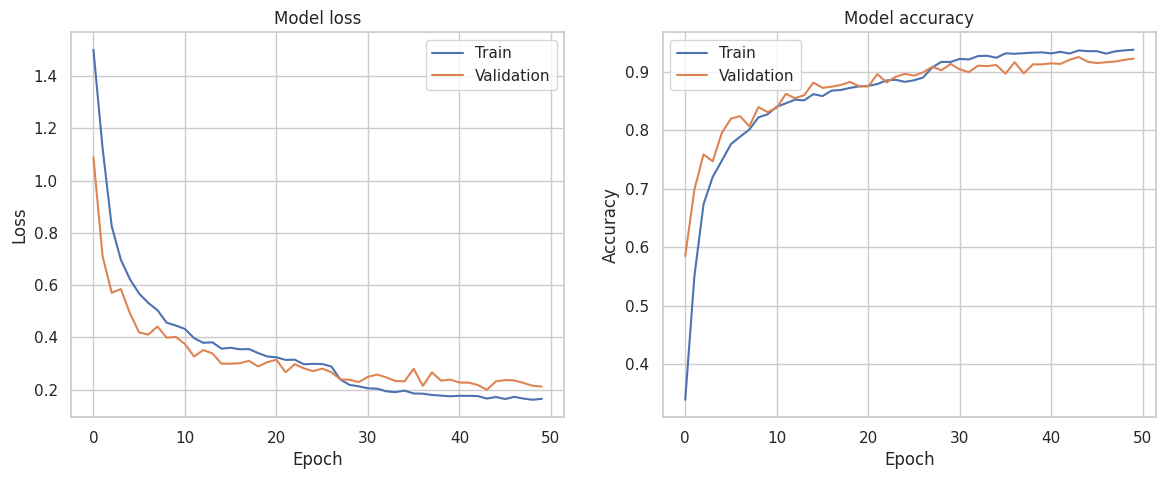

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step
              precision    recall  f1-score   support

    ELEPHANT       0.83      0.89      0.86       548
       HORSE       0.92      0.84      0.88       541
        LION       0.89      0.90      0.90       536
         cat       1.00      1.00      1.00       547
         dog       0.99      0.99      0.99       525

    accuracy                           0.93      2697
   macro avg       0.93      0.93      0.93      2697
weighted avg       0.93      0.93      0.93      2697



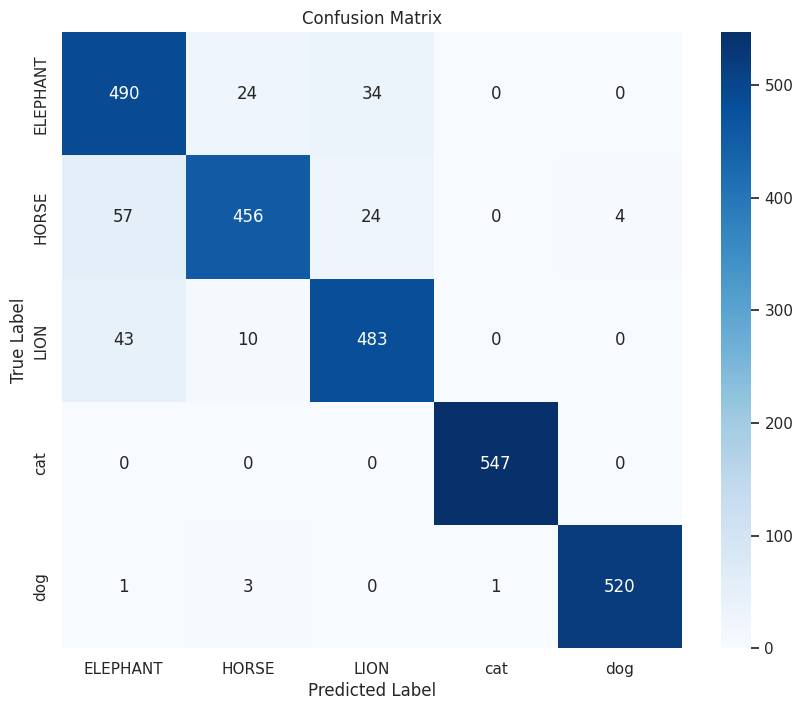

In [7]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('Model accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history(history)

validation_generator.reset()
preds = model.predict(validation_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)

conf_matrix = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Comprehensive Model Evaluation

This cell defines a helper function `plot_history` and performs a complete evaluation of the trained model. The process is divided into three key stages:

1.  **Visualizing Learning Curves**:
    - The `plot_history` function extracts accuracy and loss metrics from the training history.
    - It plots **Training vs. Validation Accuracy** and **Training vs. Validation Loss** side-by-side.
    - **Goal**: These plots are essential for diagnosing model behavior. Large gaps between training and validation lines typically indicate **overfitting**, while low performance on both suggests **underfitting**.

2.  **Generating Predictions**:
    - `validation_generator.reset()`: Ensures the data generator starts from the beginning so predictions align correctly with true labels.
    - `model.predict()`: Outputs the probability scores for each class.
    - `np.argmax()`: Converts probabilities into final class predictions.

3.  **Performance Metrics & Confusion Matrix**:
    - **Classification Report**: Provides a detailed text summary of Precision, Recall, and F1-Score for each mammal class.
    - **Confusion Matrix Heatmap**: Visually displays the specific misclassifications.
        - **X-axis**: Predicted Labels.
        - **Y-axis**: True Labels.
        - **Diagonal**: Correct predictions.
        - **Off-diagonal**: Errors (e.g., how often the model confused Class A for Class B).

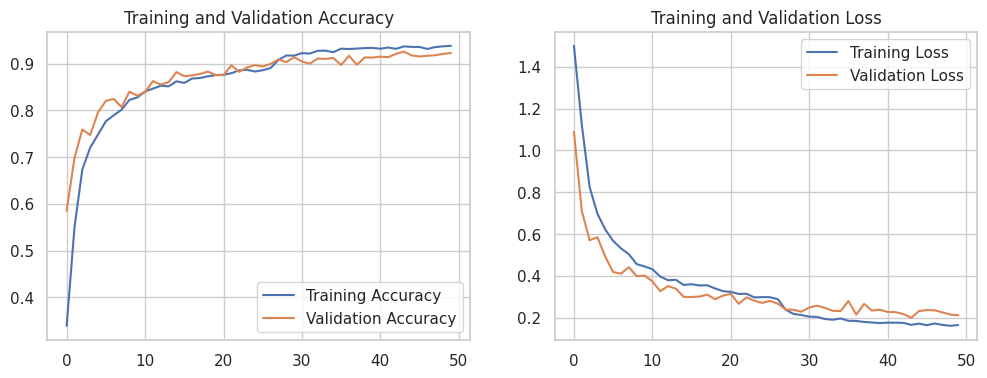

Generating Confusion Matrix...
85/85 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
              precision    recall  f1-score   support

    ELEPHANT       0.83      0.89      0.86       548
       HORSE       0.92      0.84      0.88       541
        LION       0.89      0.90      0.90       536
         cat       1.00      1.00      1.00       547
         dog       0.99      0.99      0.99       525

    accuracy                           0.93      2697
   macro avg       0.93      0.93      0.93      2697
weighted avg       0.93      0.93      0.93      2697



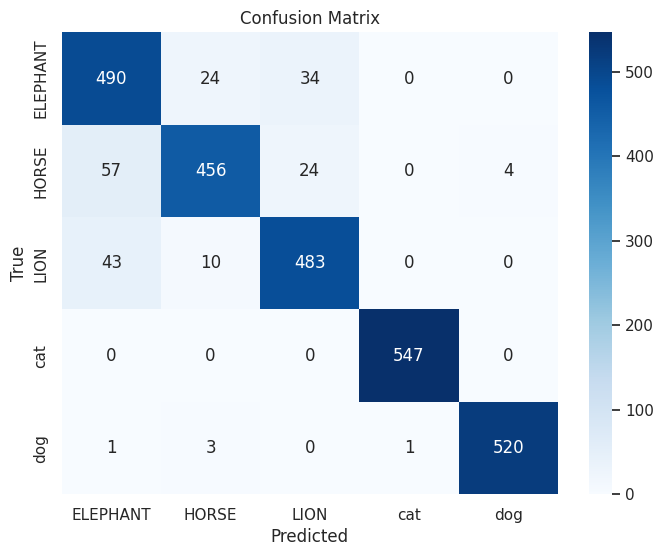

In [8]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

print("Generating Confusion Matrix...")
validation_generator.reset()
preds = model.predict(validation_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print(classification_report(true_classes, pred_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Load Best Baseline Model

In this step, we explicitly load the best-performing version of our Custom CNN.

**Why is this necessary?**
Although `EarlyStopping` can restore weights, explicitly loading the saved model file (`custon-cnn.keras`) guarantees that we are evaluating the exact version of the model that achieved the highest validation accuracy during training. This avoids using the weights from the final epoch, which might have started to overfit or diverge.

**Steps:**
1.  **Load Model**: Retrieves the saved `custon-cnn.keras` file.
2.  **Verify Data**: We replot the validation set distribution as a sanity check to ensure the data generator is correctly connected and balanced before running the final predictions.

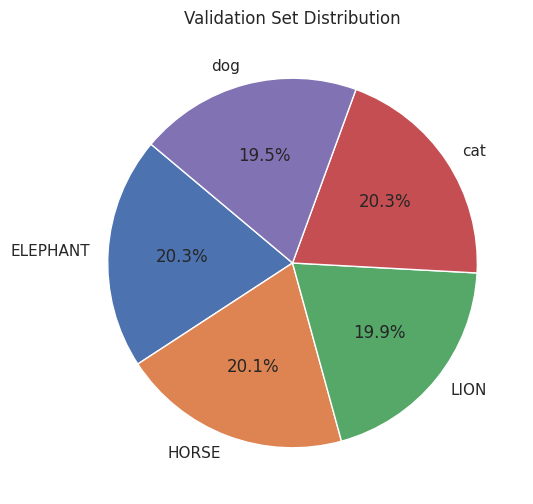

In [9]:
from tensorflow.keras.models import load_model
model = load_model('custon-cnn.keras')

plot_class_distribution_pie(validation_generator, 'Validation Set Distribution')


# Build ResNet50V2 Model

This cell defines the `build_resnet50v2` function, which constructs a ResNet50V2 model with pre-trained weights from ImageNet. The model is customized for the specific classification task by adding new layers on top of the pre-trained base model. The steps include:

1. **Build ResNet50V2 Function**:
    - The function `build_resnet50v2` takes `img_size` and `num_classes` as parameters:
        - `img_size`: The size to which each input image will be resized.
        - `num_classes`: The number of output classes for the classification task.

2. **Base Model**:
    - The ResNet50V2 model is loaded with pre-trained weights from ImageNet, excluding the top classification layer (`include_top=False`).
    - The input shape is defined as `(img_size, img_size, 3)` to match the dimensions of the input images.

3. **Freezing the Base Model**:
    - All layers in the base model are set to non-trainable by freezing them. This prevents the pre-learned features (like edge detection) from being destroyed/updated during the initial training phase.

4. **Adding Custom Layers**:
    - **GlobalAveragePooling2D**: Reduces each feature map to a single value, drastically reducing parameter count.
    - **Dense Layer**: Adds a fully connected layer with 512 units and ReLU activation to learn dataset-specific patterns.
    - **Dropout Layer**: Adds a dropout layer with a rate of 0.5 to prevent overfitting.
    - **Predictions Layer**: Adds a final fully connected layer with `num_classes` units and softmax activation for multi-class classification.

5. **Compile the Model**:
    - The model is compiled with the `categorical_crossentropy` loss function and `Adam` optimizer.
    - `accuracy` is used as the evaluation metric.
    - The model summary is printed to provide an overview of the architecture.

The function returns the compiled model, ready for training.

In [13]:
def build_resnet50v2(img_size, num_classes):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.summary()

    return model

model = build_resnet50v2(img_size, num_classes)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,616,453 (93.90 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# Train the ResNet50V2 Model

This cell initiates the training process for our Transfer Learning model.

**Training Strategy:**
-   **Epochs (20)**: We set the maximum epochs to 20. Although ResNet converges quickly, this higher limit combined with `EarlyStopping` gives the model flexibility.
-   **Safety Net**: Since our `earlystopping` patience is set to 10, setting `epochs=20` ensures the callback has enough room to monitor performance and stop training automatically if the model stops improving. This prevents overfitting while ensuring we don't under-train.

**Training Configuration:**
-   **train_generator**: Feeds the augmented training images.
-   **validation_data**: Evaluates the model on unseen data after every epoch.
-   **Callbacks**: Utilizes `checkpoint_resnet50v2` to save the best weights and `ReduceLROnPlateau` to fine-tune the learning rate when progress stalls.

-   The training metrics are stored in `history_resnet`, which allows us to compare the learning curve against the baseline model later.

In [14]:
history_resnet = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[checkpoint_resnet50v2,earlystopping,learning_rate_reduction]
) 

Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8671 - loss: 0.4138
Epoch 1: val_loss did not improve from 0.11632
338/338 ━━━━━━━━━━━━━━━━━━━━ 148s 414ms/step - accuracy: 0.8672 - loss: 0.4133 - val_accuracy: 0.9559 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 2/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9375 - loss: 0.1717
Epoch 2: val_loss did not improve from 0.11632
338/338 ━━━━━━━━━━━━━━━━━━━━ 132s 389ms/step - accuracy: 0.9375 - loss: 0.1717 - val_accuracy: 0.9570 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 3/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9439 - loss: 0.1451
Epoch 3: val_loss improved from 0.11632 to 0.10174, saving model to resnet50v2.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 133s 394ms/step - accuracy: 0.9439 - loss: 0.1451 - val_accuracy: 0.9637 - val_loss: 0.1017 - learning_rate: 0.0010
Epoch 4/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9448 - loss: 0.1448
Epoch 4: val_loss did not improve 

# Evaluation and Visualization of ResNet50V2

In this step, we perform a comprehensive evaluation of our Transfer Learning model to assess its performance.

**The process consists of three parts:**

1.  **Visualizing Training History**:
    -   We define a helper function `plot_history_resnet` to display the Loss and Accuracy curves.
    -   This helps us verify that the model converged correctly and check for any signs of overfitting.

2.  **Loading the Best Model**:
    -   **Crucial Step**: We explicitly load the saved checkpoint `resnet50v2.keras`.
    -   This ensures that our confusion matrix and classification report reflect the **best** version of the model (lowest validation loss), rather than the weights from the very last epoch.

3.  **Performance Metrics**:
    -   **Classification Report**: detailed Precision, Recall, and F1-Scores for each mammal class.
    -   **Confusion Matrix**: A heatmap visualization to pinpoint exactly which animals are being confused with each other.

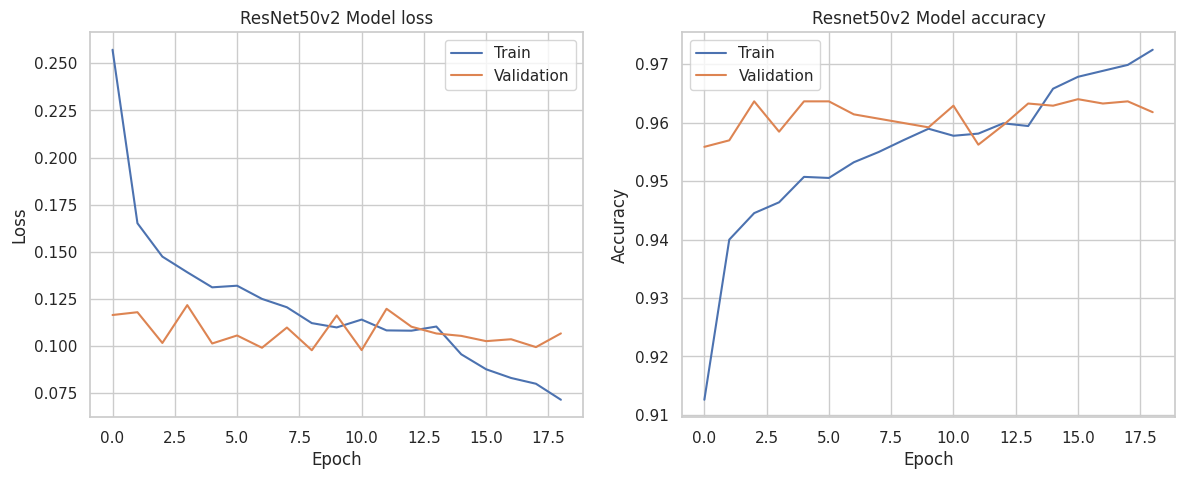

Loading best ResNet50V2 model...
Generating predictions...
85/85 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    ELEPHANT       0.90      0.96      0.93       548
       HORSE       0.97      0.87      0.92       541
        LION       0.94      0.96      0.95       536
         cat       1.00      1.00      1.00       547
         dog       1.00      1.00      1.00       525

    accuracy                           0.96      2697
   macro avg       0.96      0.96      0.96      2697
weighted avg       0.96      0.96      0.96      2697



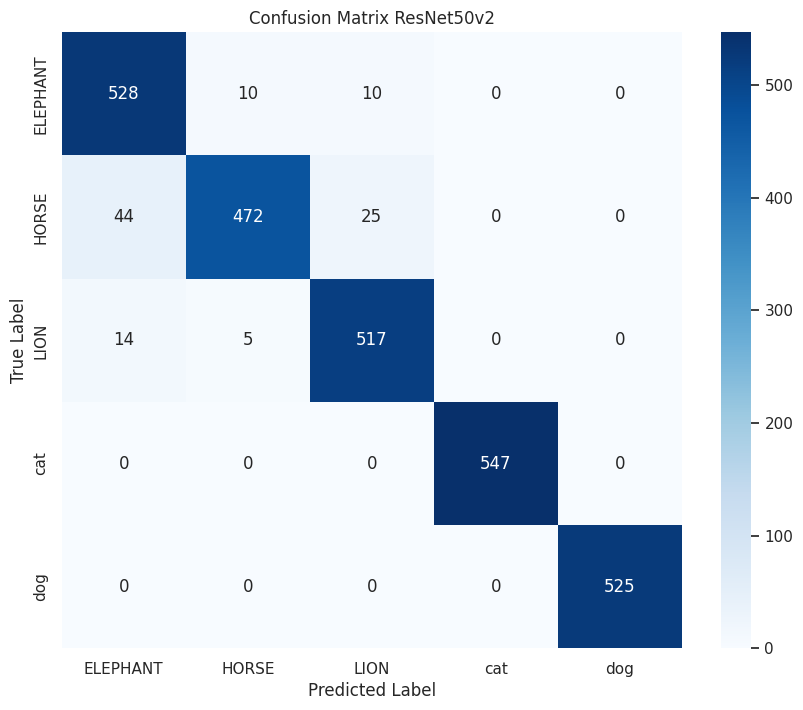

In [15]:
def plot_history_resnet(history_resnet):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history_resnet.history['loss'])
    ax1.plot(history_resnet.history['val_loss'])
    ax1.set_title('ResNet50v2 Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')

    ax2.plot(history_resnet.history['accuracy'])
    ax2.plot(history_resnet.history['val_accuracy'])
    ax2.set_title('Resnet50v2 Model accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_history_resnet(history_resnet)


from tensorflow.keras.models import load_model
print("Loading best ResNet50V2 model...")
model = load_model('resnet50v2.keras')

print("Generating predictions...")
validation_generator.reset()
preds = model.predict(validation_generator)
pred_classes = np.argmax(preds, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

print("\n--- CLASSIFICATION REPORT ---")
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)

conf_matrix = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix ResNet50v2')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Visualizing Error Analysis

In this final step, we perform a **qualitative analysis** by visualizing the images the model got wrong.

**Why is this important?**
Metrics like "85% accuracy" are abstract. By looking at the actual misclassified images, we can hypothesize about the causes of error:
-   **Ambiguity**: Is the image blurry or dark?
-   **similarity**: Does this specific Wolf look very similar to a Dog?
-   **Background**: Is the animal camouflaged?

**The Code:**
1.  **Identify Errors**: Creates a boolean mask to find indices where the prediction did not match the true label.
2.  **Random Sample**: Selects up to 6 random error images to display (so we don't overcrowd the screen).
3.  **Visualization**: Plots the images with their **True Label** and the model's **Incorrect Prediction** in red.

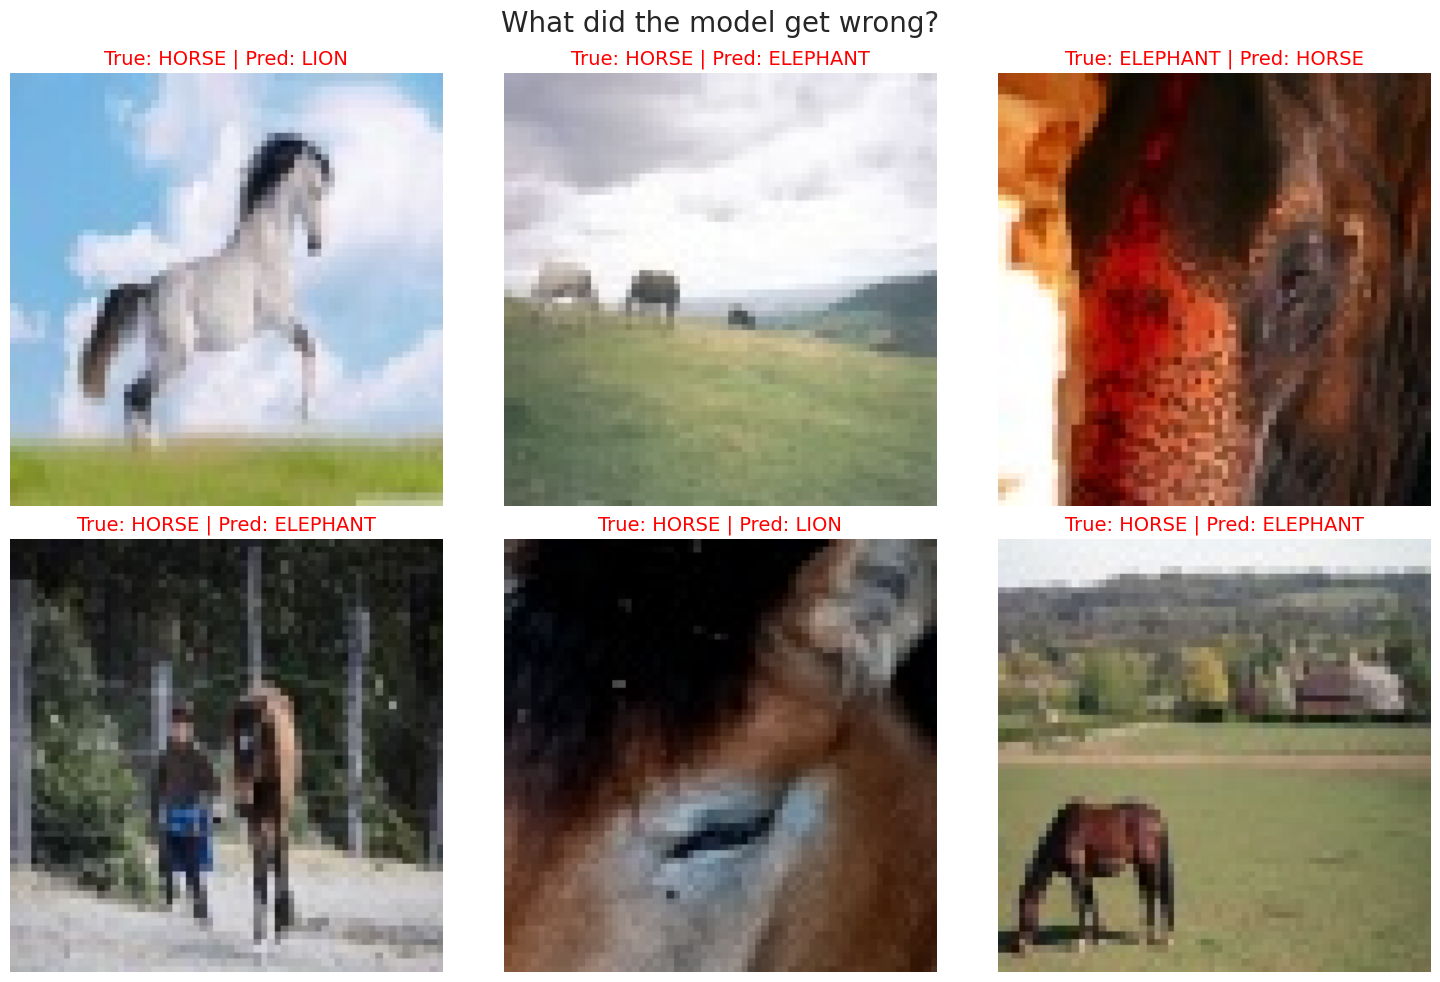

In [16]:
errors = (pred_classes - true_classes != 0)

y_true_errors = true_classes[errors]
y_pred_errors = pred_classes[errors]

error_file_paths = [validation_generator.filepaths[i] for i, val in enumerate(errors) if val]

plt.figure(figsize=(15, 10))

num_images_to_plot = min(6, len(error_file_paths))
indices = np.random.choice(len(error_file_paths), num_images_to_plot, replace=False)

for i, idx in enumerate(indices):
    img_path = error_file_paths[idx]
    img = load_img(img_path, target_size=(224, 224))
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    
    true_label = class_labels[y_true_errors[idx]]
    pred_label = class_labels[y_pred_errors[idx]]
    
    plt.title(f"True: {true_label} | Pred: {pred_label}", color='red', fontsize=14)
    plt.axis('off')

plt.suptitle("What did the model get wrong?", fontsize=20)
plt.tight_layout()
plt.show()

Custom CNN Best Accuracy: 92.55%
ResNet50V2 Best Accuracy: 96.40%


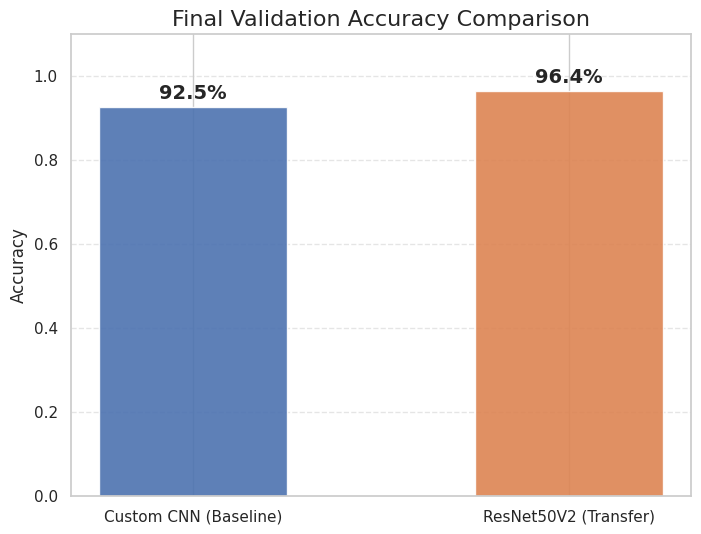

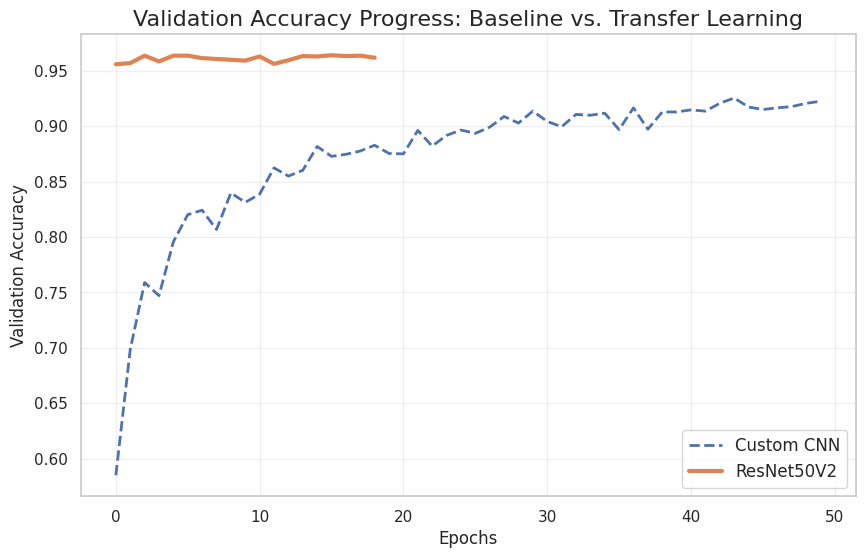

In [18]:
cnn_best_acc = max(history.history['val_accuracy'])
resnet_best_acc = max(history_resnet.history['val_accuracy'])

print(f"Custom CNN Best Accuracy: {cnn_best_acc:.2%}")
print(f"ResNet50V2 Best Accuracy: {resnet_best_acc:.2%}")

models = ['Custom CNN (Baseline)', 'ResNet50V2 (Transfer)']
accuracies = [cnn_best_acc, resnet_best_acc]
colors = ['#4c72b0', '#dd8452'] 

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=colors, alpha=0.9, width=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.1%}',
             ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.title('Final Validation Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


plt.figure(figsize=(10, 6))

plt.plot(history.history['val_accuracy'], label='Custom CNN', linestyle='--', linewidth=2, color='#4c72b0')

plt.plot(history_resnet.history['val_accuracy'], label='ResNet50V2', linewidth=3, color='#dd8452')

plt.title('Validation Accuracy Progress: Baseline vs. Transfer Learning', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()